<a href="https://colab.research.google.com/github/KormazovaVer/project_ml/blob/main/Jewels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# загружаем библиотеки
import os
import time
import glob
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from random import randint

from sklearn.model_selection import train_test_split

import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [ ]:
# подключаем свой Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# загрузим датасет со своего Google Drive
# предварительно скачиваем датасет с kaggle: https://www.kaggle.com/datasets/lsind18/gemstones-images
!mkdir -p data

!cp drive/MyDrive/jewels/test.zip data/
!cp drive/MyDrive/jewels/train.zip data/

!unzip -o -qq data/test.zip -d data/
!unzip -o -qq data/train.zip -d data/

!rm -r  data/train.zip
!rm -r  data/test.zip

In [ ]:
def count_files_in_directories(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        print(f"Directory: {dirpath}, File count: {len(filenames)}")


count_files_in_directories('data/train/')

Directory: data/train/, File count: 0
Directory: data/train/Onyx Red, File count: 28
Directory: data/train/Aventurine Yellow, File count: 34
Directory: data/train/Zircon, File count: 33
Directory: data/train/Quartz Rutilated, File count: 38
Directory: data/train/Onyx Black, File count: 28
Directory: data/train/Zoisite, File count: 28
Directory: data/train/Prehnite, File count: 37
Directory: data/train/Morganite, File count: 31
Directory: data/train/Peridot, File count: 39
Directory: data/train/Grossular, File count: 29
Directory: data/train/Aquamarine, File count: 36
Directory: data/train/Ruby, File count: 35
Directory: data/train/Amber, File count: 31
Directory: data/train/Quartz Lemon, File count: 33
Directory: data/train/Spessartite, File count: 30
Directory: data/train/Tanzanite, File count: 36
Directory: data/train/Sapphire Pink, File count: 30
Directory: data/train/Emerald, File count: 36
Directory: data/train/Hessonite, File count: 30
Directory: data/train/Serpentine, File count

In [ ]:
def count_files_in_directories(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        print(f"Directory: {dirpath}, File count: {len(filenames)}")

count_files_in_directories('data/test/')

Directory: data/test/, File count: 0
Directory: data/test/Onyx Red, File count: 4
Directory: data/test/Aventurine Yellow, File count: 4
Directory: data/test/Zircon, File count: 4
Directory: data/test/Quartz Rutilated, File count: 5
Directory: data/test/Onyx Black, File count: 4
Directory: data/test/Zoisite, File count: 4
Directory: data/test/Prehnite, File count: 5
Directory: data/test/Morganite, File count: 4
Directory: data/test/Peridot, File count: 5
Directory: data/test/Grossular, File count: 4
Directory: data/test/Aquamarine, File count: 5
Directory: data/test/Ruby, File count: 4
Directory: data/test/Amber, File count: 4
Directory: data/test/Quartz Lemon, File count: 4
Directory: data/test/Spessartite, File count: 4
Directory: data/test/Tanzanite, File count: 4
Directory: data/test/Sapphire Pink, File count: 4
Directory: data/test/Emerald, File count: 5
Directory: data/test/Hessonite, File count: 4
Directory: data/test/Serpentine, File count: 4
Directory: data/test/Variscite, File

87 classes with 3219 images in total


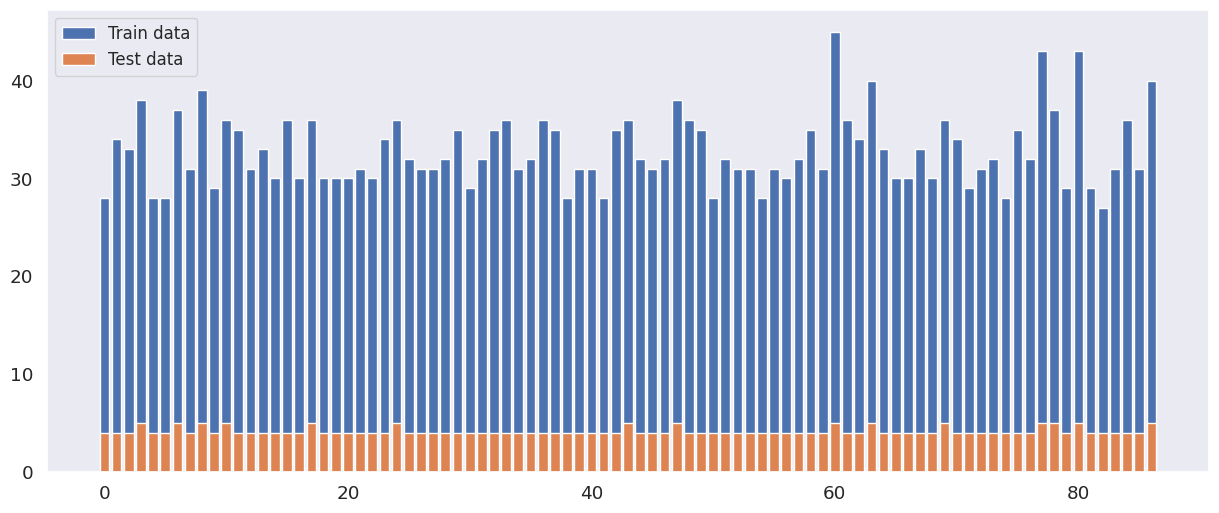

In [ ]:
CLASSES, gems = [], []

for root, dirs, files in os.walk('data/'):
    f = os.path.basename(root)
    if len(files) > 0:
         gems.append(len(files))
         if f not in CLASSES:
             CLASSES.append(f) # add folder name

gems_count = len(CLASSES) # 87 = number of classes
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))


f, ax = plt.subplots(figsize=(15,6))
if(gems[0])<10:
     plt.bar(range(gems_count), gems[gems_count:], label = 'Train data')
     plt.bar(range(gems_count), gems[0:gems_count], label = 'Test data')
else:
     plt.bar(range(gems_count), gems[0:gems_count], label = 'Train data')
     plt.bar(range(gems_count), gems[gems_count:], label = 'Test data')
ax.grid()
ax.legend(fontsize = 12);

In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/train"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 1999
Изображений в val: 857


In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(
                    (224, 224), scale=(0.8, 1), ratio=(3 / 4, 4 / 3)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))


Количество классов в train:  87
Количество классов в val:  87
Количество классов одинаково:  True


In [ ]:
data_dir_1 = "data/test"
data_image_paths_1 = glob.glob(f"{data_dir_1}/*/*.jpg")

print(
    f"Изображений в test: {len(data_image_paths_1)}")

Изображений в test: 363


In [ ]:
print(f"Процент тестовой выборки: {((len(data_image_paths_1) * 100) // (len(data_image_paths_1) + len(train_files_path) + len(val_files_path)))}%")

Процент тестовой выборки: 11%


In [ ]:
input_size = 224

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_dataset = torchvision.datasets.ImageFolder(
    data_dir_1,
    transform=test_transform,
    is_valid_file=lambda x: x in data_image_paths_1
)


In [ ]:
print("Количество классов в test ", len(test_dataset.classes))

Количество классов в test  87


In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
val_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
test_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
# Вывод изображений и их меток на печать для предварительного просмотра
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=3, ncols=3, figsize=(8, 8),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=800)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((2, 1, 0)))

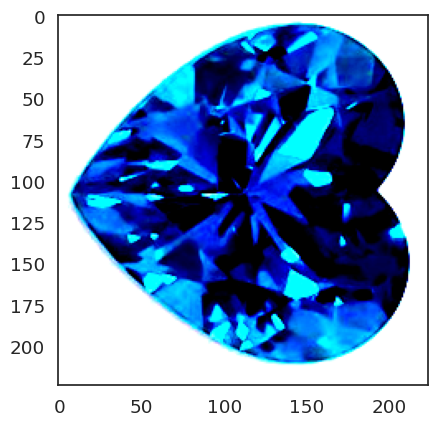

Alexandrite


In [ ]:
image,label = train_dataset[20]
plt.imshow(image.permute(2,1,0))
plt.show()
print(train_dataset.classes[label])

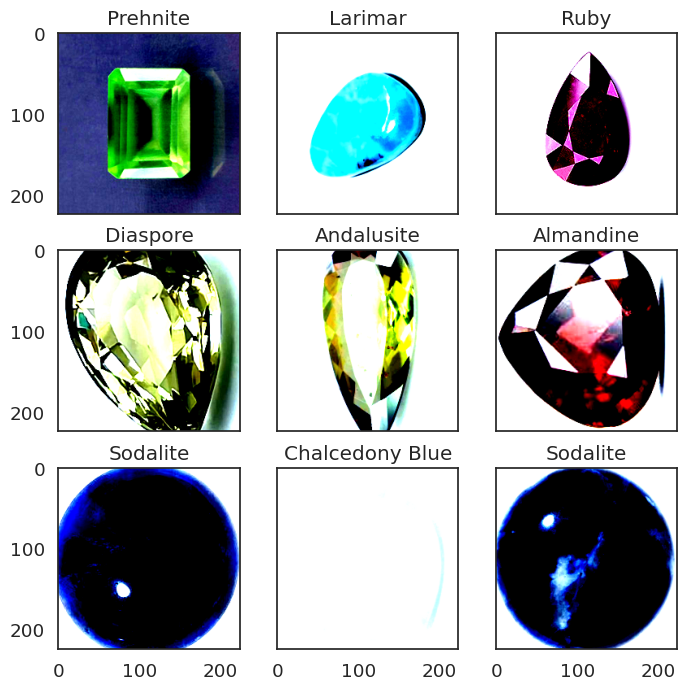

In [ ]:
show_images(val_dataset)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    scheduler,
    num_epochs
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()



            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)


        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        scheduler.step()

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 128

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
     train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
from torchvision.models import resnet18

In [ ]:
model = resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 28 of 28 took 18.384s
  training loss (in-iteration): 	0.034486
  validation loss (in-iteration): 	0.854233
  training accuracy: 			99.63 %
  validation accuracy: 			78.11 %


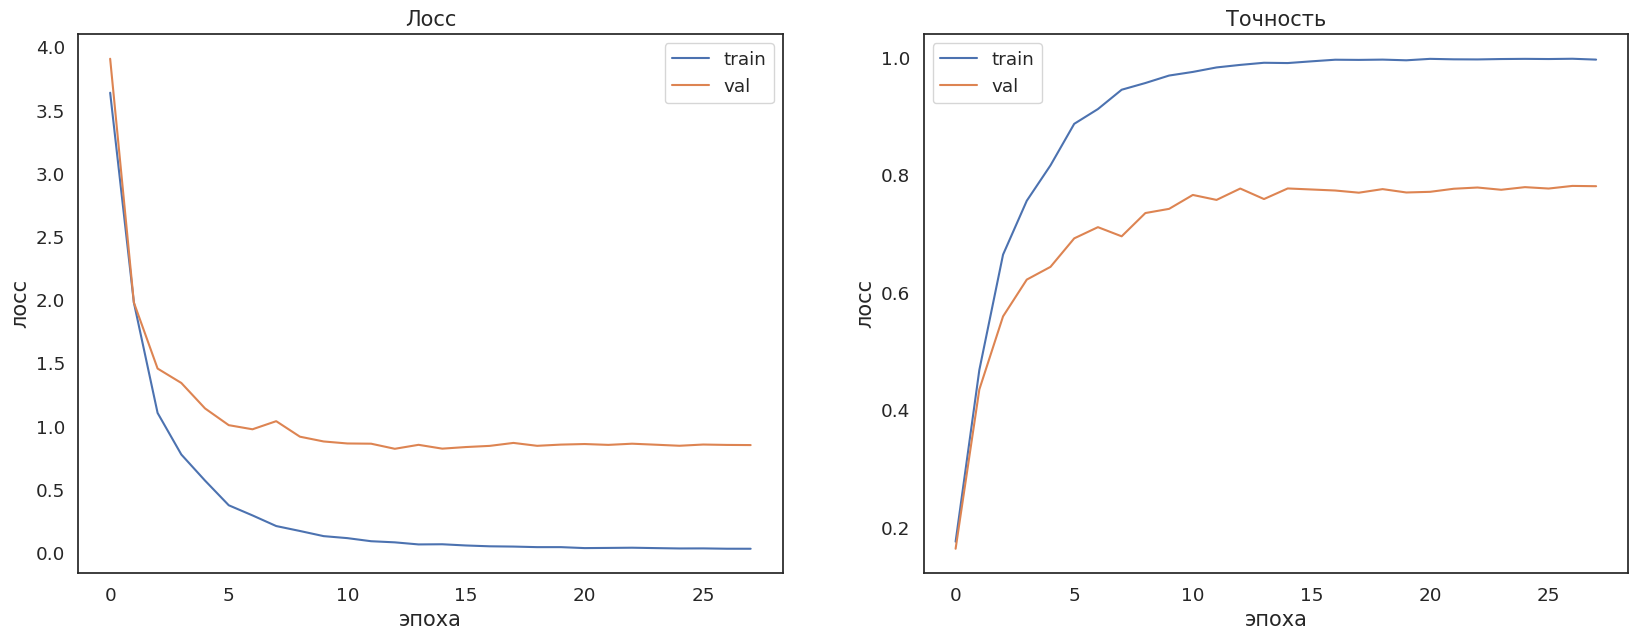

In [ ]:
fine_tuning_model_sched = nn.Sequential()

fine_tuning_model_sched.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model_sched.add_module('relu_1', nn.ReLU())
fine_tuning_model_sched.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model_sched.add_module('relu_2', nn.ReLU())
fine_tuning_model_sched.add_module('fc_2', nn.Linear(512, 87))

fine_tuning_model_sched = fine_tuning_model_sched.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model_sched.parameters(), lr=0.1)

# добавим scheduler ExponentialLR для уменьшения скорости обучения каждой группы параметров на гамму в каждую эпоху
scheduler = ExponentialLR(optimizer,
                          gamma=0.9)

clf_model, history = train(
    fine_tuning_model_sched, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=28
)

In [ ]:
def prediction(images, model):
    xb = (images.unsqueeze(0)).to(device)
    out = model(xb)
    _,preds = torch.max(out, dim=1)
    prediction = train_dataset.classes[preds[0].item()]
    return prediction

Label: Alexandrite
Prediction: Alexandrite


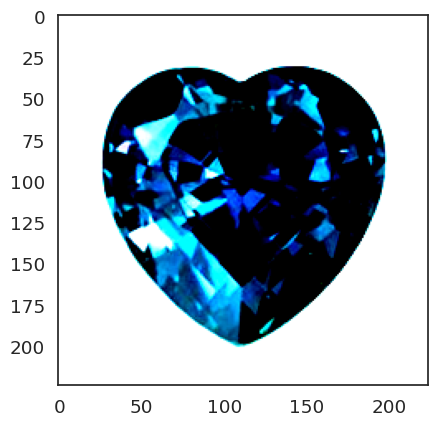

In [ ]:
images, labels = test_dataset[2]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_sched))
plt.imshow(images.permute(1,2,0))

Label: Andradite
Prediction: Andalusite


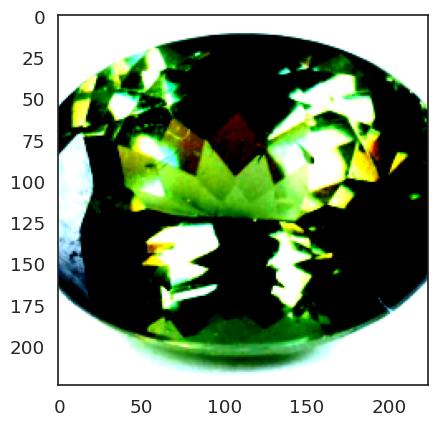

In [ ]:
images, labels = test_dataset[30]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_sched))
plt.imshow(images.permute(1,2,0))

Label: Citrine
Prediction: Spessartite


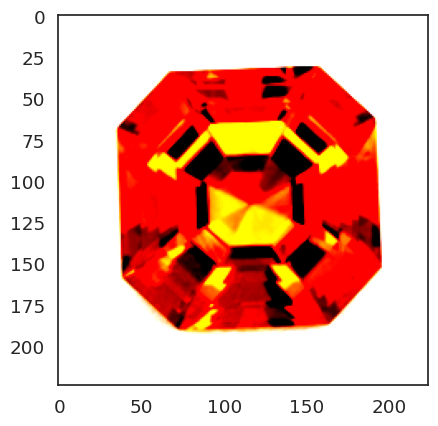

In [ ]:
images, labels = test_dataset[100]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_sched))
plt.imshow(images.permute(1,2,0))

Label: Peridot
Prediction: Peridot


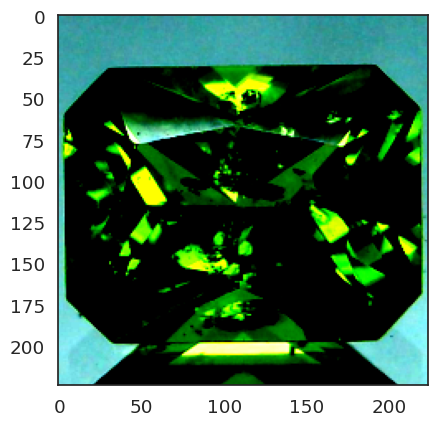

In [ ]:
images, labels = test_dataset[222]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_sched))
plt.imshow(images.permute(1,2,0))

Label: Turquoise
Prediction: Turquoise


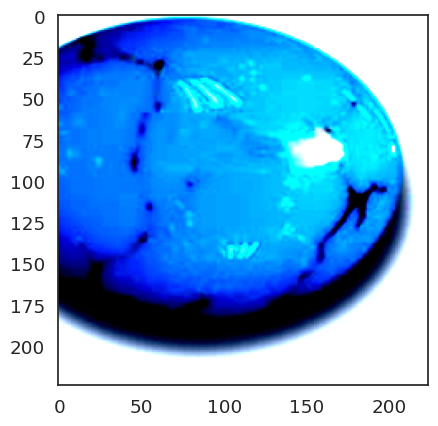

In [ ]:
images, labels = test_dataset[350]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_sched))
plt.imshow(images.permute(1,2,0))

In [ ]:
from torchvision.models import vgg16

In [ ]:
model = vgg16(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 28 of 28 took 43.011s
  training loss (in-iteration): 	0.026339
  validation loss (in-iteration): 	1.171307
  training accuracy: 			98.97 %
  validation accuracy: 			79.41 %


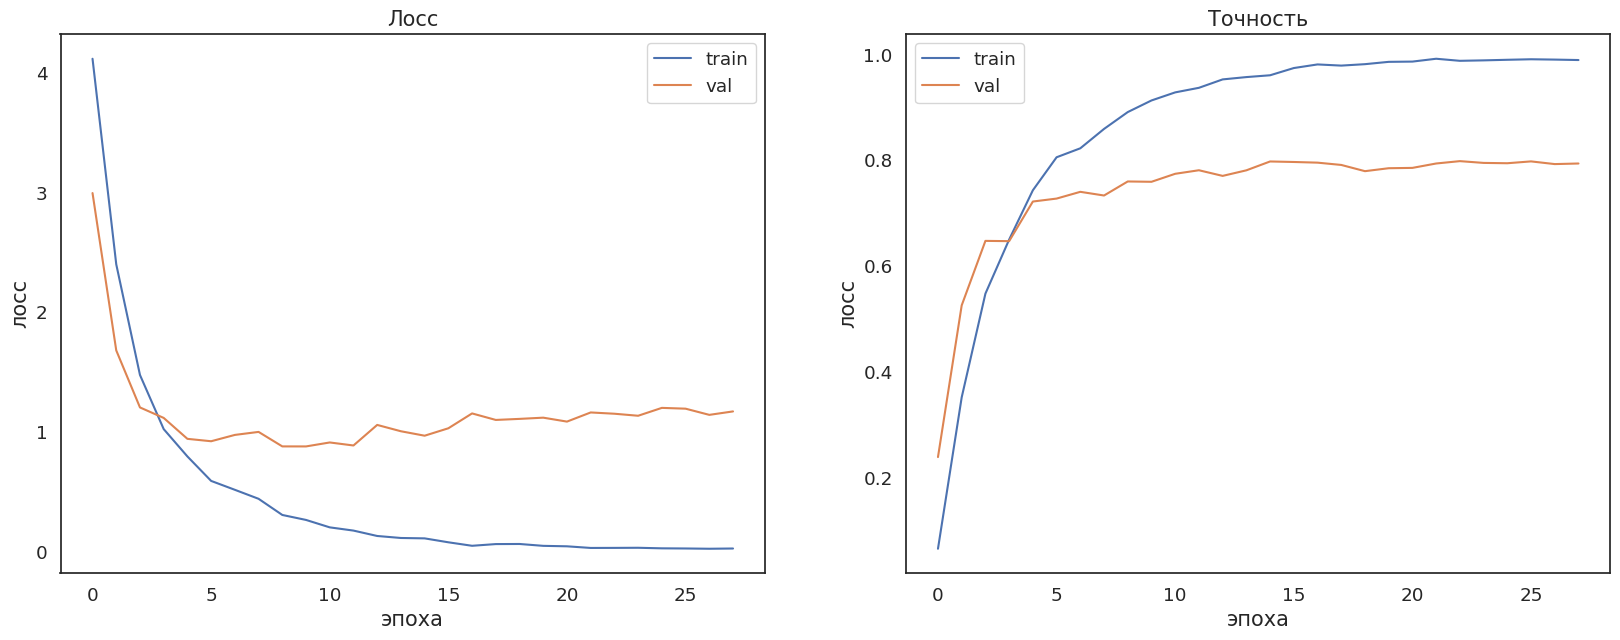

In [ ]:
fine_tuning_model_2_sched = nn.Sequential()

fine_tuning_model_2_sched.add_module('vgg', vgg16(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
# Add on classifier
fine_tuning_model_2_sched._modules['6'] = nn.Sequential(
                      nn.Linear(in_features=1000, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=87, bias=True)
                      )

fine_tuning_model_2_sched = fine_tuning_model_2_sched.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_tuning_model_2_sched.parameters(), lr=0.0001)

# добавим scheduler ExponentialLR для уменьшения скорости обучения каждой группы параметров на гамму в каждую эпоху
scheduler = ExponentialLR(optimizer,
                          gamma = 0.9)

clf_model, history = train(
    fine_tuning_model_2_sched, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=28
)


Label: Amazonite
Prediction: Amazonite


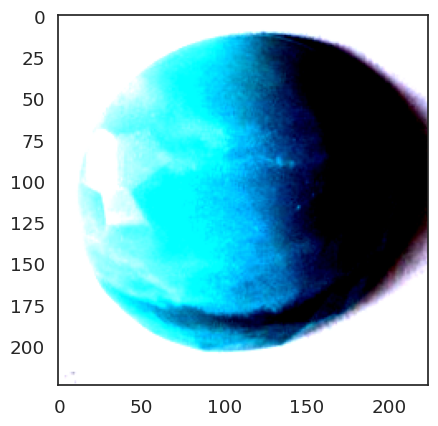

In [ ]:
images, labels = test_dataset[10]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_2_sched))
plt.imshow(images.permute(1,2,0))

Label: Bixbite
Prediction: Bixbite


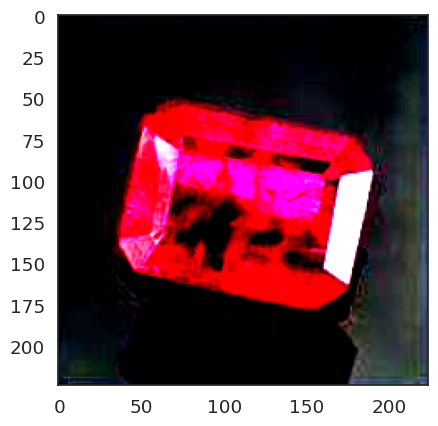

In [ ]:
images, labels = test_dataset[55]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_2_sched))
plt.imshow(images.permute(1,2,0))

Label: Dumortierite
Prediction: Dumortierite


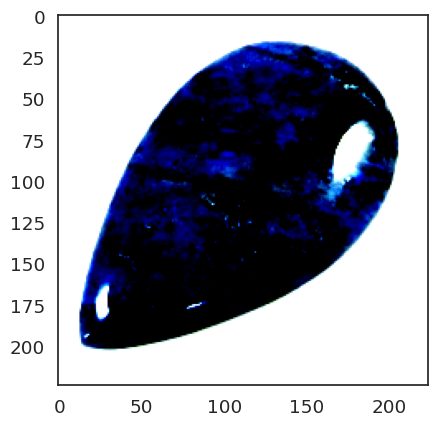

In [ ]:
images, labels = test_dataset[123]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_2_sched))
plt.imshow(images.permute(1,2,0))

Label: Prehnite
Prediction: Prehnite


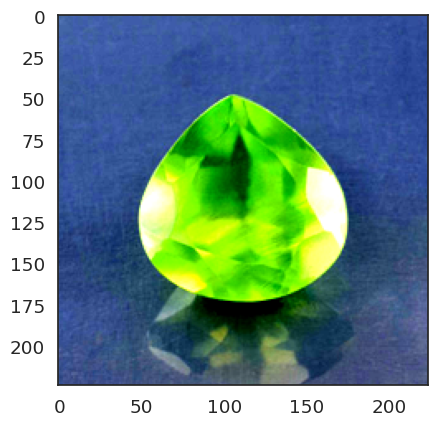

In [ ]:
images, labels = test_dataset[230]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_2_sched))
plt.imshow(images.permute(1,2,0))

Label: Tourmaline
Prediction: Tourmaline


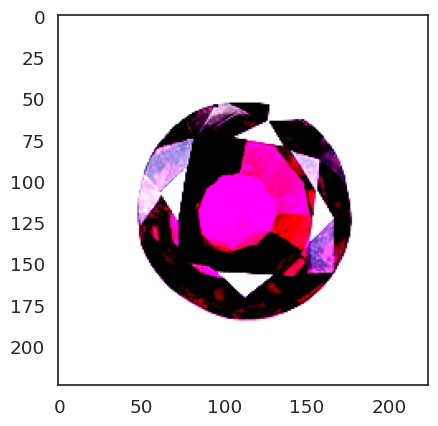

In [ ]:
images, labels = test_dataset[340]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_2_sched))
plt.imshow(images.permute(1,2,0))

In [ ]:
n_classes = len(np.unique(val_dataset.classes))
print("we will classify :{}".format(n_classes))

we will classify :87


In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
idxs = list(map(int, np.random.uniform(0,len(val_dataset), 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims_resnet = predict(fine_tuning_model_sched, imgs)
probs_ims_vgg = predict(fine_tuning_model_2_sched, imgs)
y_pred_resnet = np.argmax(probs_ims_resnet,-1)
y_pred_vgg = np.argmax(probs_ims_vgg,-1)
y_pred_resnet = list(y_pred_resnet)
y_pred_vgg = list(y_pred_vgg)
print('ResNet18:     ', y_pred_resnet)
print('VGG16:        ', y_pred_vgg)
actual_labels = [val_dataset[id][1] for id in idxs]
y_pred=[]
for i in range(len(actual_labels)):
    if y_pred_resnet[i] == y_pred_vgg[i]:
        y_pred.append(y_pred_vgg[i])
    elif probs_ims_resnet[i,y_pred_resnet[i]] > probs_ims_vgg[i,y_pred_vgg[i]]:
        y_pred.append(y_pred_resnet[i])
    else:
        y_pred.append(y_pred_vgg[i])
print('Ensemble:     ', y_pred)
print('Right answer: ', actual_labels)

ResNet18:      [23, 46, 40, 80, 69, 11, 46, 12, 30, 18, 37, 52, 2, 67, 56, 7, 81, 46, 64, 9]
VGG16:         [23, 46, 40, 85, 69, 11, 46, 12, 30, 18, 37, 52, 2, 67, 56, 74, 32, 50, 64, 9]
Ensemble:      [23, 46, 40, 80, 69, 11, 46, 12, 30, 18, 37, 52, 2, 67, 56, 7, 32, 50, 64, 9]
Right answer:  [23, 46, 40, 80, 12, 11, 46, 12, 30, 18, 37, 52, 2, 67, 1, 53, 81, 50, 64, 9]


In [ ]:
from sklearn.metrics import f1_score
sc_resnet=f1_score(actual_labels, y_pred_resnet, average='macro')
print ('ResNet18: F1_score=', sc_resnet)
sc_vgg=f1_score(actual_labels, y_pred_vgg, average='macro')
print ('VGG16: F1_score=', sc_vgg)
sc=f1_score(actual_labels, y_pred, average='macro')
print ('Ensemble: F1_score=',sc)

ResNet18: F1_score= 0.8046085374573746
VGG16: F1_score= 0.8118793977414667
Ensemble: F1_score= 0.8174633183354114


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

def show_confusion_matrix_fucn(model):

    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()


    with torch.no_grad():
        for inputs, labels in val_batch_gen:
            predictions = model(inputs.to(device))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)


            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(val_batch_gen.dataset.classes))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()


    cm = confusion_matrix(y_test_all, predictions_all)#, np.arange(n_classes))

    plot_confusion_matrix(cm, feature_names, normalize=True)

    return y_test_all, predictions_all

def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(n_classes)]
    class_total = [0 for i in range(n_classes)]
    feature_names = sorted(set(val_batch_gen.dataset.classes))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(n_classes):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [ ]:
BATCH_SIZE = 64

dataloaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset)}

ResNet:
Normalized confusion matrix
[9, 9, 11, 8, 10, 12, 12, 12, 14, 14, 12, 16, 9, 11, 11, 11, 12, 9, 8, 8, 8, 7, 13, 9, 11, 8, 11, 9, 11, 11, 11, 10, 10, 9, 4, 6, 4, 10, 10, 11, 11, 8, 11, 8, 8, 7, 11, 11, 9, 8, 9, 9, 10, 15, 11, 13, 8, 13, 7, 9, 11, 7, 8, 10, 9, 9, 6, 9, 10, 8, 8, 9, 13, 10, 8, 7, 17, 13, 9, 13, 12, 8, 11, 10, 9, 8, 8]
87
Accuracy of Alexandrite : 77 %
Accuracy of Almandine : 44 %
Accuracy of Amazonite : 81 %
Accuracy of Amber : 87 %
Accuracy of Amethyst : 80 %
Accuracy of Ametrine : 75 %
Accuracy of Andalusite : 58 %
Accuracy of Andradite : 41 %
Accuracy of Aquamarine : 71 %
Accuracy of Aventurine Green : 92 %
Accuracy of Aventurine Yellow : 83 %
Accuracy of Benitoite : 50 %
Accuracy of Beryl Golden : 55 %
Accuracy of Bixbite : 81 %
Accuracy of Bloodstone : 100 %
Accuracy of Blue Lace Agate : 90 %
Accuracy of Carnelian : 83 %
Accuracy of Cats Eye : 100 %
Accuracy of Chalcedony : 87 %
Accuracy of Chalcedony Blue : 100 %
Accuracy of Chrome Diopside : 87 %
Accuracy o

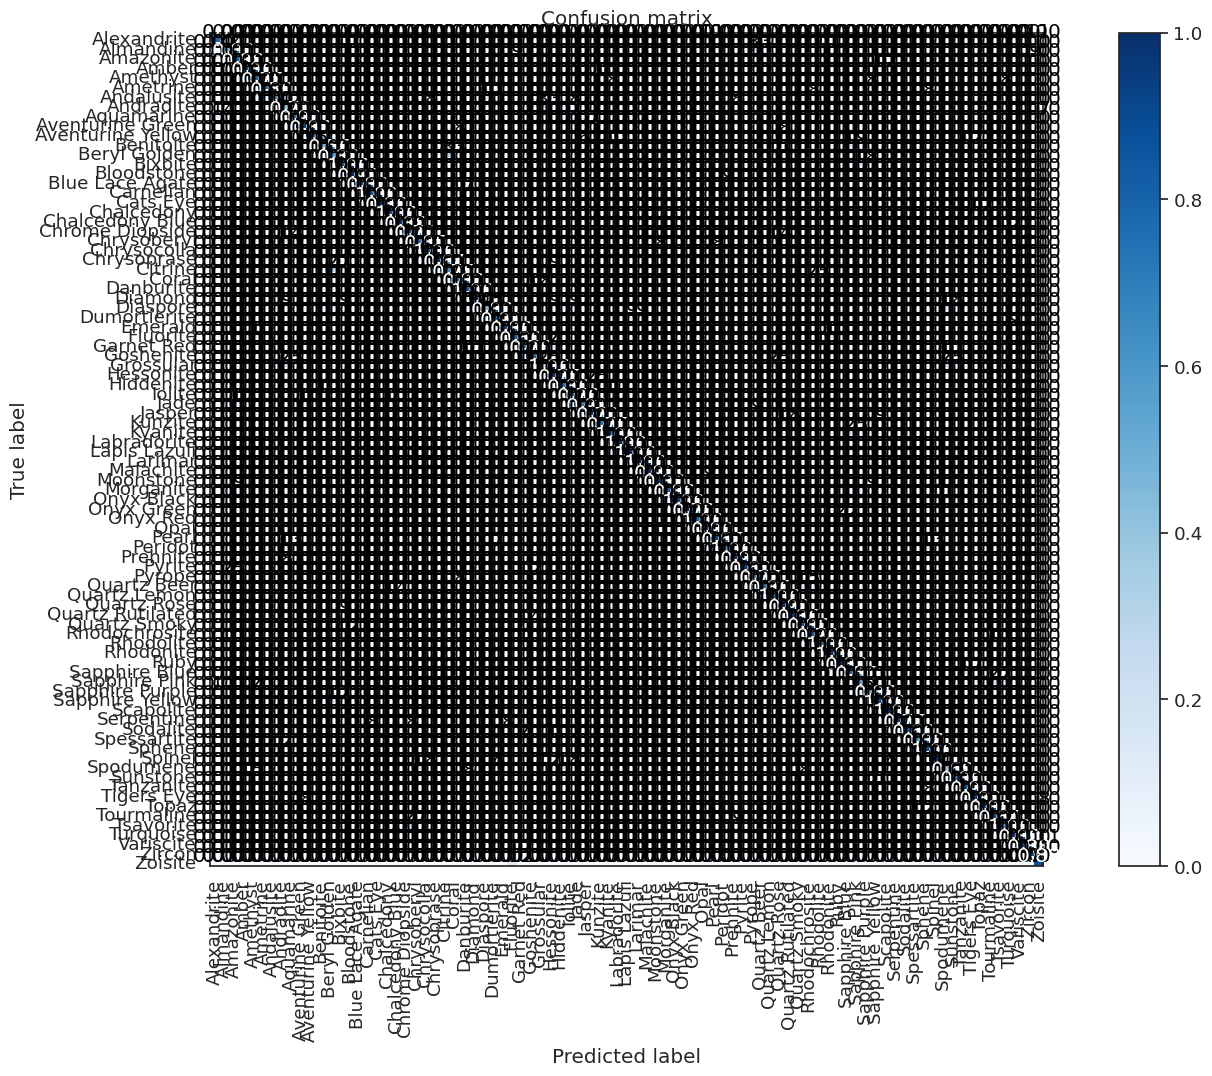

In [ ]:
print ('ResNet:')
y_test_all, predictions_all = show_confusion_matrix_fucn(fine_tuning_model_sched)
accurancy_for_each_class(y_test_all, predictions_all)

VGG:
Normalized confusion matrix
[10, 10, 10, 10, 11, 12, 11, 7, 15, 13, 10, 5, 9, 12, 11, 9, 11, 9, 8, 11, 11, 12, 15, 11, 11, 8, 13, 9, 8, 9, 12, 10, 13, 6, 6, 6, 10, 12, 10, 9, 15, 10, 13, 10, 9, 7, 10, 9, 8, 8, 10, 9, 11, 8, 11, 18, 12, 11, 9, 9, 12, 9, 7, 6, 9, 9, 7, 7, 7, 9, 9, 9, 10, 10, 9, 6, 16, 9, 11, 14, 11, 8, 10, 8, 9, 9, 5]
87
Accuracy of Alexandrite : 80 %
Accuracy of Almandine : 50 %
Accuracy of Amazonite : 90 %
Accuracy of Amber : 80 %
Accuracy of Amethyst : 72 %
Accuracy of Ametrine : 66 %
Accuracy of Andalusite : 54 %
Accuracy of Andradite : 57 %
Accuracy of Aquamarine : 66 %
Accuracy of Aventurine Green : 100 %
Accuracy of Aventurine Yellow : 100 %
Accuracy of Benitoite : 100 %
Accuracy of Beryl Golden : 55 %
Accuracy of Bixbite : 83 %
Accuracy of Bloodstone : 90 %
Accuracy of Blue Lace Agate : 100 %
Accuracy of Carnelian : 90 %
Accuracy of Cats Eye : 100 %
Accuracy of Chalcedony : 87 %
Accuracy of Chalcedony Blue : 81 %
Accuracy of Chrome Diopside : 72 %
Accuracy o

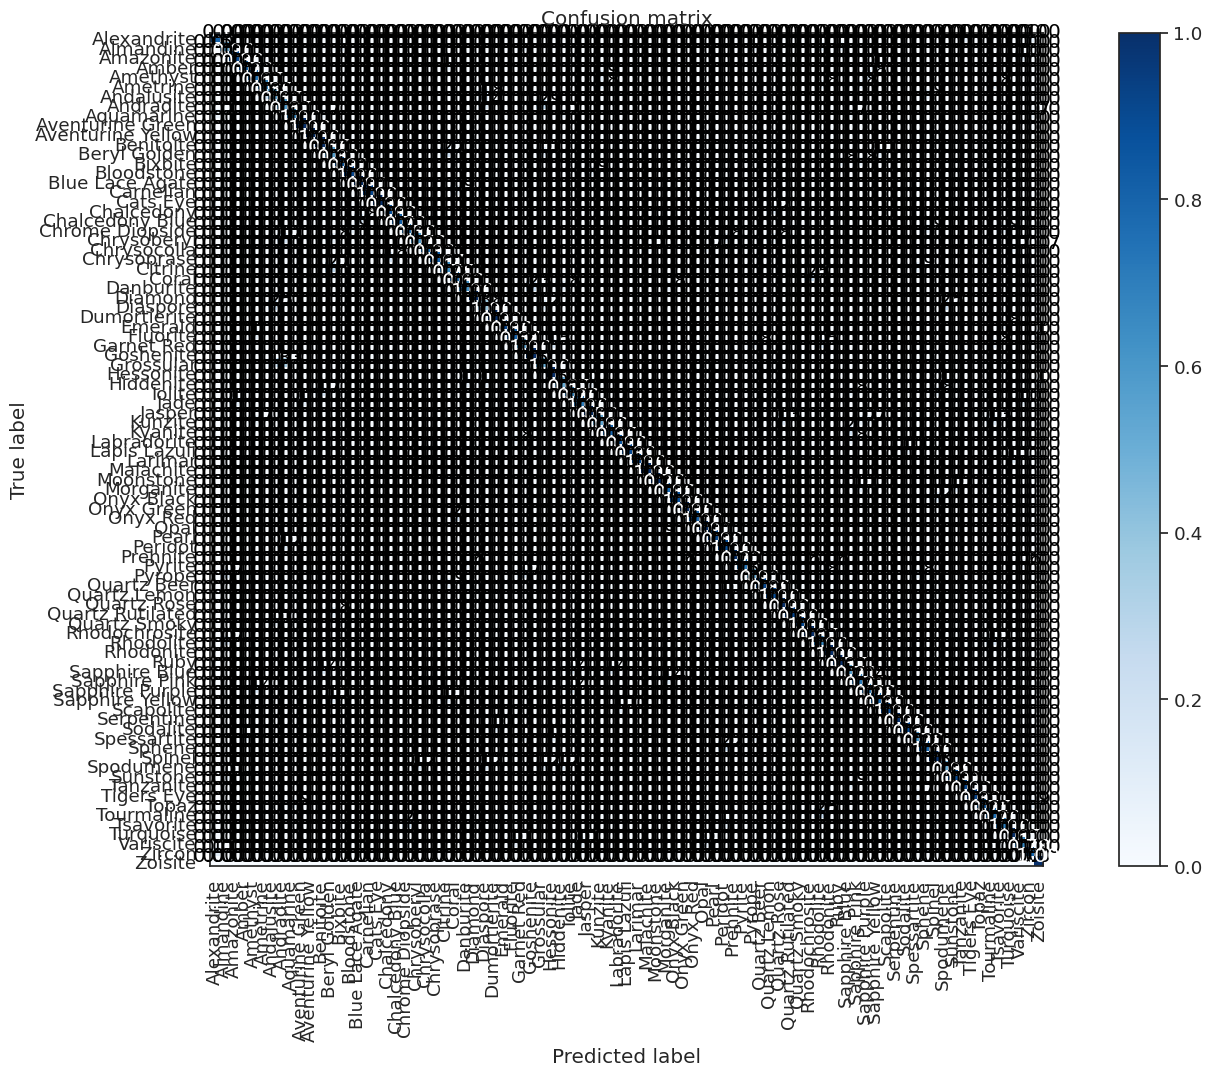

In [ ]:
print ('VGG:')
y_test_all, predictions_all = show_confusion_matrix_fucn(fine_tuning_model_2_sched)
accurancy_for_each_class(y_test_all, predictions_all)